<a href="https://colab.research.google.com/github/lodi-m/US-Traffic-Accidents-Analysis/blob/main/EDA_us_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Traffic Accidents Exploratory Data Analysis

## Introduction

### What is Exploratory Data Analysis (EDA)? 
Exploratory data analysis is used to investigate datasets to summarize their main characteristics and draw conclusions *before* any formal statistical modeling or inference is made. It is a crucial first step in the data analysis procedure as it help save time and resources in the future. EDA is especially useful in discovering patterns, locating any abnormalities and finding any interesting relations in the data.

In this notebook we'll analyze a car accident dataset from the USA. This current version of the dataset contains information from 4.2 million traffic accidents during *February 2016* - *December 2020* that took place all over the Contiguous United States. The data was collected using multiple Traffic APIs, such as MapQuest and Bing, and several other data providers. 

Although this dataset can be used for a variety of applications, we will be focusing on how **precipitation** and other **environmental factors** impacted the accidents. 

If you would like to learn more about the raw data itself please visit: https://smoosavi.org/datasets/us_accidents 


#### Downloading the data


In [1]:
pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/sobhanmoosavi/us-accidents" 
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: malihalodi
Your Kaggle Key: ··········


100%|██████████| 117M/117M [00:02<00:00, 57.7MB/s]


### Data Preparation and Cleaning 



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import folium
from folium.plugins import HeatMap
sns.set_style("darkgrid")

In [5]:
raw_df = pd.read_csv("/content/us-accidents/US_Accidents_Dec20_updated.csv")

In [6]:
raw_df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

As you can see, there is a lot more information than we want currently in the dataset. For example, we won't really need to worry about what amenities there were or if there was a roundabout near the accident. We are only focused on the *environmental factors* in this notebook. 

Please also note that we will only be looking at the time of day in relation to Nautical Twilight. This is because Nautical Twilight takes place right in between Civil and Astronomical Twilight. I felt that if we used the other twilights, there would be a bit of bias in regards to what is considered "Day" or "Night". As such, I chose to just use the middle value. 

<img src="https://c.tadst.com/gfx/1200x630/twiligh-phases.png?1" alt="Different Types of Twilights and their degrees" width="500"/>

If you would like to read more about the differences between Civil, Nautical, and Astronomical Twilight please visit: https://www.weather.gov/lmk/twilight-types



Now let's go ahead and only select the columns we are interested in. 

In [7]:
selected_columns = ['ID', 'Severity', 'Start_Time', 'End_Time',
                     'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
                    'Description', 'City', 'State', 'Timezone', 'Weather_Timestamp',
                    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                    'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
                    'Precipitation(in)', 'Weather_Condition', 
                    'Sunrise_Sunset', 'Nautical_Twilight']

len(selected_columns)

25

In [8]:
len(raw_df.columns)

47

Note that we've about halved the amount of columns! That's about half of the dataset that we're not interested in. 

Let's now go ahead and make a new copy of the data, containing only the information we want called <code> weather_df </code>. Using <code> weather_df </code>, we can continue to modify and analyze further without actually affecting the original data and dataframe.

In [9]:
weather_df = raw_df[selected_columns].copy()

Let's just get a better idea of whats inside <code>weather_df</code>

In [10]:
weather_df.shape

(1516064, 25)

In [11]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516064 entries, 0 to 1516063
Data columns (total 25 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ID                 1516064 non-null  object 
 1   Severity           1516064 non-null  int64  
 2   Start_Time         1516064 non-null  object 
 3   End_Time           1516064 non-null  object 
 4   Start_Lat          1516064 non-null  float64
 5   Start_Lng          1516064 non-null  float64
 6   End_Lat            1516064 non-null  float64
 7   End_Lng            1516064 non-null  float64
 8   Distance(mi)       1516064 non-null  float64
 9   Description        1516064 non-null  object 
 10  City               1515981 non-null  object 
 11  State              1516064 non-null  object 
 12  Timezone           1513762 non-null  object 
 13  Weather_Timestamp  1485800 non-null  object 
 14  Temperature(F)     1473031 non-null  float64
 15  Wind_Chill(F)      1066748 non-n

Before moving forwards, let's also take care of any missing or Null values. We'll first see exactly how many missing values we have. 

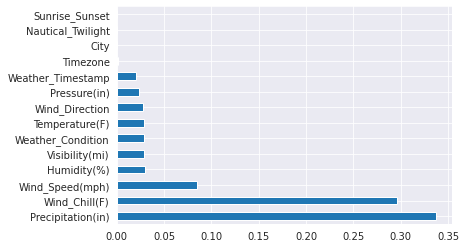

In [12]:
missing_percentage = weather_df.isna().sum().sort_values(ascending = False) / len(weather_df)
missing_percentage[missing_percentage != 0].plot(kind = "barh")

From the graph we can see that *End_Lat* and *End_Lng* have the greatest amount of missing values, followed by *Precipitation* and *Wind_Chill*. 

We won't worry about the missing *End_Lat* and *End_Lng* values ***just*** yet as these missing values may indicate that that the vehicle simply did not move after the accident. In some states, moving the car after a crash is actually illegal so this may also be a factor in the missing values. 



In [13]:
weather_df.dropna(subset = ["Humidity(%)", "Weather_Condition", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Wind_Chill(F)"], inplace=True)

Let's just making sure that the missing values were actually dropped. 
Note that we are not dropping *all* of the columns. The remaining ones just have such a small amount of missing values that it won't really have an affect on the analysis down the road. 

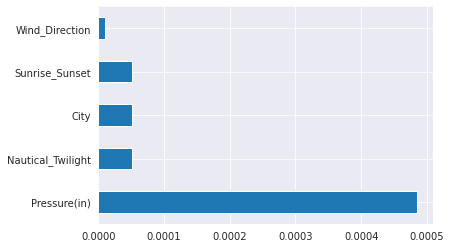

In [14]:
missing_percentage = weather_df.isna().sum().sort_values(ascending = False) / len(weather_df)
missing_percentage[missing_percentage != 0].plot(kind = "barh")

Now that all of the missing values have been dealt with, lets actually get into the data and see if there are any incorrect values.

Let's start off with some basic statistics. 

In [15]:
weather_df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,942393.000000,942393.000000,942393.000000,942393.000000,942393.000000,942393.000000,942393.000000,942393.000000,942393.000000,941936.000000,942393.000000,942393.000000,942393.000000
mean,2.141445,36.758442,-98.954588,36.758525,-98.954390,0.540687,58.580591,57.248111,65.336387,29.337329,9.007635,7.117961,0.005498
std,0.521697,5.274378,18.617010,5.274356,18.616817,1.592057,17.876607,19.999494,23.352754,1.148373,2.733962,5.709367,0.073428
min,1.000000,24.570584,-124.497567,24.574326,-124.497478,0.000000,-27.000000,-50.100000,1.000000,19.370000,0.000000,0.000000,0.000000
25%,2.000000,33.823677,-118.249750,33.823529,-118.249695,0.000000,46.000000,44.000000,49.000000,29.160000,10.000000,3.000000,0.000000
50%,2.000000,36.845260,-94.504185,36.845010,-94.503528,0.085000,59.000000,59.000000,69.000000,29.720000,10.000000,7.000000,0.000000
75%,2.000000,40.697090,-80.776238,40.697090,-80.777210,0.517000,72.000000,72.000000,85.000000,29.960000,10.000000,10.000000,0.000000
max,4.000000,49.000580,-67.484130,49.075000,-67.484130,155.186000,113.000000,113.000000,100.000000,58.040000,100.000000,984.000000,24.000000


There seems to be a problem with the Distance(mi) column. The maximum distance is a car moved during the accident is about 251 miles. This value seems a bit too high, and as such, seems unreliable and unrealistic.  

There are similiar problems with Temperature(F), Wind_Chill(F) and Wind_Speed(mph) columns. The maximum value in each of these columns seems too high to be realistic. For example, it does not make sense that the temperature during the accident was 174 degrees Farenheit when the highest recorded temperature ever on Earth is 134 degrees Farenheit (set on July 10, 1913). 

A simple fix for these unrealistic and unreliable values are to simply exclude them from our analysis. 

In [16]:
weather_df.drop(weather_df[weather_df["Distance(mi)"] > 100].index, inplace=True)
weather_df.drop(weather_df[weather_df["Temperature(F)"] > 134].index, inplace=True)
weather_df.drop(weather_df[weather_df["Wind_Chill(F)"] > 60].index, inplace=True)
weather_df.drop(weather_df[weather_df["Wind_Speed(mph)"] > 231].index, inplace=True)

In [17]:
weather_df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,491332.000000,491332.000000,491332.000000,491332.000000,491332.000000,491332.000000,491332.000000,491332.000000,491332.000000,491073.000000,491332.000000,491332.000000,491332.000000
mean,2.135605,38.723268,-99.568496,38.723360,-99.568291,0.574270,44.750127,42.194476,72.995663,29.256297,8.528764,6.493224,0.006644
std,0.491691,4.545442,18.956911,4.545407,18.956603,1.597287,11.841722,14.853455,19.370222,1.263346,3.039203,5.754215,0.094802
min,1.000000,24.574326,-124.497567,24.574546,-124.497478,0.000000,-27.000000,-50.100000,4.000000,19.480000,0.000000,0.000000,0.000000
25%,2.000000,34.731442,-118.910659,34.731385,-118.910753,0.000000,37.900000,34.000000,61.000000,29.100000,9.000000,0.000000,0.000000
50%,2.000000,38.908649,-94.738600,38.907766,-94.739013,0.103000,47.000000,45.000000,77.000000,29.650000,10.000000,6.000000,0.000000
75%,2.000000,42.178155,-80.796645,42.178148,-80.797960,0.564000,54.000000,54.000000,89.000000,29.980000,10.000000,9.000000,0.000000
max,4.000000,49.000580,-67.484130,49.075000,-67.484130,99.791000,60.000000,60.000000,100.000000,58.040000,100.000000,169.000000,24.000000


I will also go ahead and save this data for easy use in the future. By doing so, I won't have to start with the raw dataset and clean it every single time I work on this project.

In [18]:
weather_df.to_csv('/content/us-accidents/clean_data.csv', index = False)

In [20]:
weather_df = pd.read_csv("/content/us-accidents/clean_data.csv")

In [21]:
weather_df['ID'].count()

491332

Note that we only have about 500 000 entries left in our dataset after cleaning and preparing it! We originally had over 4.2 million entries. That's about 3.5 million entries which were unusable for either containing null/missing values or have unrealistic information inside. 

We've now cleaned up and prepared the dataset for analysis. Let's take a look at a sample of rows from the data frame. 

In [22]:
weather_df.sample(10)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,City,State,Timezone,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Nautical_Twilight
274189,A-3481180,3,2020-05-08 16:37:56,2020-05-08 17:27:54,41.558550,-87.846830,41.558550,-87.846830,0.000,At 88th Ave - Accident.,Tinley Park,IL,US/Central,2020-05-08 16:35:00,45.0,40.0,49.0,29.35,10.0,E,8.0,0.0,Partly Cloudy,Day,Day
41064,A-3015061,2,2020-12-07 19:22:12,2020-12-07 21:20:25,29.997946,-90.059283,29.997071,-90.059207,0.061,Incident on ELYSIAN FIELDS AVE near FOY ST Dri...,New Orleans,LA,US/Central,2020-12-07 18:53:00,58.0,58.0,56.0,30.14,10.0,NNW,15.0,0.0,Fair,Night,Night
368248,A-3701206,2,2020-01-24 17:50:00,2020-01-24 18:47:59,34.091908,-117.991346,34.091908,-117.991346,0.000,At I-605/San Gabriel River Fwy - Accident.,Baldwin Park,CA,US/Pacific,2020-01-24 17:53:00,58.0,58.0,84.0,29.86,5.0,SSW,5.0,0.0,Partly Cloudy,Night,Day
221241,A-3350378,2,2020-12-12 01:03:26,2020-12-12 03:15:44,33.546857,-117.716235,33.548039,-117.714293,0.138,Incident on KITE HILL DR near ALICIA PKWY Driv...,Laguna Niguel,CA,US/Pacific,2020-12-12 00:53:00,52.0,52.0,80.0,30.02,9.0,CALM,0.0,0.0,Fair,Night,Night
61781,A-3053447,2,2020-12-28 12:06:00,2020-12-28 14:22:35,34.033252,-118.130623,34.033210,-118.144534,0.797,WB 60 JWO GARFIELD. 82-N25 SEMI'S ON THEIR WAY...,Montebello,CA,US/Pacific,2020-12-28 12:00:00,57.0,57.0,64.0,29.79,10.0,SE,5.0,0.0,Light Rain,Day,Day
313268,A-3610016,2,2020-03-30 20:49:00,2020-03-30 22:02:45,36.522776,-121.459693,36.522776,-121.459693,0.000,At Old Stage Rd - Accident.,Gonzales,CA,US/Pacific,2020-03-30 20:53:00,54.0,54.0,80.0,30.21,10.0,WSW,5.0,0.0,Fair,Night,Night
419603,A-3775739,2,2019-12-13 09:28:00,2019-12-13 10:22:05,44.969990,-93.329370,44.969990,-93.329370,0.000,Ramp to I-394 Eastbound - Accident.,Minneapolis,MN,US/Central,2019-12-13 09:53:00,13.0,4.0,84.0,29.03,5.0,SSE,6.0,0.0,Cloudy,Day,Day
466038,A-3934498,4,2019-01-29 16:43:58,2019-01-29 17:13:42,38.550840,-90.493550,38.550840,-90.493550,0.000,Closed at MO-141/Meramec Station Rd - Road clo...,Valley Park,MO,US/Central,2019-01-29 16:54:00,19.9,6.7,71.0,30.19,8.0,NW,13.8,0.0,Overcast,Day,Day
390258,A-3733358,2,2020-02-20 12:19:32,2020-02-20 12:47:09,38.772520,-76.886520,38.764110,-76.882870,0.613,At MD-223/Woodyard Rd - Accident.,Clinton,MD,US/Eastern,2020-02-20 11:56:00,38.0,34.0,34.0,30.15,10.0,NE,5.0,0.0,Mostly Cloudy,Day,Day
90342,A-3106457,2,2020-12-09 08:30:00,2020-12-09 15:45:36,30.448107,-87.321844,30.447843,-87.322666,0.052,Incident on CERNY RD near NANDINA DR Drive wit...,Pensacola,FL,US/Central,2020-12-09 08:53:00,57.0,57.0,74.0,30.08,10.0,W,8.0,0.0,Fair,Day,Day


## **Exploratory Analysis and Visualization**
Let's begin by seeing where exactly the accidents are occuring. We'll do this by taking a 10% sample of the data and using the "Start Longitude" and "Start Latitude" columns.

In [23]:
location_df = weather_df.sample(int(0.1 * len(weather_df)))

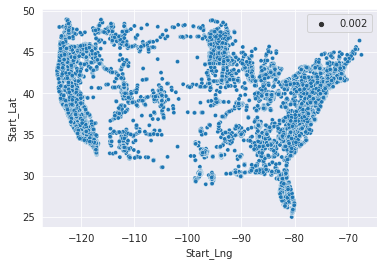

In [24]:
sns.scatterplot(x = location_df.Start_Lng, y = location_df.Start_Lat, size = 0.002)

In [25]:
latitude_longitude_pairs = list(zip(list(location_df.Start_Lat), list(location_df.Start_Lng)))

In [26]:
map = folium.Map()
HeatMap(latitude_longitude_pairs, radius=20).add_to(map)
map

#### **Accidents per state**
Let's get a more granular look into each of the states. I'm going to go more in-depth into some of the weather columns here.

In [27]:
col_list = []
col_list.append(weather_df.groupby(by='State')['ID'].count())
for col in ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Distance(mi)']:
  avg_df = pd.DataFrame({f'avg_{col}': weather_df.groupby(by='State')[f'{col}'].mean()})
  median_df = pd.DataFrame({f'median_{col}': weather_df.groupby(by='State')[f'{col}'].median()})
  col_list.append(avg_df)
  col_list.append(median_df)
per_state = pd.concat(col_list, axis=1).rename(columns={'ID':'num_accidents'}).sort_values(by='num_accidents', ascending=False)

In [30]:
per_state.head(10)

,num_accidents,avg_Temperature(F),median_Temperature(F),avg_Wind_Chill(F),median_Wind_Chill(F),avg_Humidity(%),median_Humidity(%),avg_Visibility(mi),median_Visibility(mi),avg_Wind_Speed(mph),median_Wind_Speed(mph),avg_Precipitation(in),median_Precipitation(in),avg_Distance(mi),median_Distance(mi)
State,,,,,,,,,,,,,,,
CA,142651,51.071645,52.0,50.532457,52.0,71.051587,75.0,8.514420,10.0,4.304241,3.0,0.006942,0.0,0.267725,0.004
OR,43953,44.693648,45.0,42.313210,42.0,78.274247,82.0,8.400683,10.0,6.720952,6.0,0.008324,0.0,0.753580,0.105
MN,36638,26.497161,27.0,18.616139,19.0,76.865877,79.0,7.843473,10.0,9.372673,8.0,0.002106,0.0,0.591498,0.065
NY,26077,42.482793,43.0,38.380258,39.0,70.379645,74.0,8.512319,10.0,9.341236,8.0,0.012822,0.0,0.690713,0.201
PA,23849,42.282972,43.0,39.157273,40.0,72.277873,75.0,8.415317,10.0,6.993476,6.0,0.006034,0.0,0.937629,0.230
VA,19828,45.920214,47.0,44.112205,45.0,74.323028,80.0,9.029622,10.0,5.911494,5.0,0.005235,0.0,0.981033,0.457
NC,14822,47.020652,49.0,45.819194,48.0,76.148226,82.0,8.642893,10.0,4.988578,5.0,0.007135,0.0,0.509329,0.087
TX,14524,48.440333,49.0,46.389245,47.0,71.639149,75.0,9.066235,10.0,7.463998,7.0,0.004499,0.0,0.506382,0.166
FL,13376,51.647137,53.0,50.833261,53.0,75.867374,80.0,9.591667,10.0,6.009046,6.0,0.000875,0.0,0.620483,0.102


We can see the top 10 states by number of accidents generally have the same average and median temperature, with the exception of Minnesota which has the lowest temperature.

## Top ten states by number of accidents

<img src="https://drive.google.com/uc?export=view&id=1eV6dXmtfTtsB_kSZvQmzfe6QjuGr8j_z" alt="top ten states by number of accidents diagram" width="450"/>

### **Some more key takeaways for all states:**
- the most common temperature per state was from **40 - 50 degrees** Fahrenheit  
- most days when accidents happened had a **humidity of 76% - 80%**
- during an accident, the distance a **vehicle traveled was 0.16 miles** on average 
- the **average wind speed** for the accidents in all states was **7.14 miles** per hour 

### **Digging deeper into when accidents tend to occur**
Let's also look at the most popular times of the day when accidents happen in each state and for how long an accident typically lasted. Even though the time an accident happened is not the main focus of this notebook, I am doing this just to understand the dataset a little bit more.

**Note:** I am adding 24 hours to the duration values that negative to make them the actual duration of the accident. A negative duration indicates that the accident started on one day, and ended on another day. By adding 24 hours to this, we can ensure that we get the correct accident duration. 
  - For example, let's consider an accident which started at 23:00 on Monday, and ended at 3:00 on Tuesday. The duration for this accident should be 4 hours, but subtracting 3:00 - 23:00 we get -20 hours. Only by adding 24 to -20, do we get the actual duration of 4 hours.



In [31]:
time_df = pd.DataFrame(
    {   'ID': weather_df.ID,
        'State': weather_df.State,
        'start_hour': weather_df.Start_Time.astype(str).str[11:13],
        'end_hour': weather_df.End_Time.astype(str).str[11:13],
        'duration': weather_df.End_Time.astype(str).str[11:13].astype(float) - weather_df.Start_Time.astype(str).str[11:13].astype(float)
     })
time_df['duration'] = time_df['duration'].mask(time_df['duration'] < 0, 24 + time_df['duration'])

In [32]:
time_df.sort_values(by='duration', ascending=False)

,ID,State,start_hour,end_hour,duration
67679,A-3064374,AZ,02,01,23.0
27985,A-2990833,WV,04,03,23.0
265833,A-3439700,WA,01,00,23.0
414352,A-3768195,CA,23,22,23.0
89625,A-3105122,WA,01,00,23.0
...,...,...,...,...,...
380506,A-3719111,NH,13,13,0.0
380505,A-3719110,MI,09,09,0.0
322776,A-3625928,CA,19,19,0.0
380503,A-3719108,CT,10,10,0.0


In [33]:
time_df['duration'].mode()

0    1.0
dtype: float64

In [34]:
time_df['start_hour'].mode()

0    01
dtype: object

In [35]:
time_df['end_hour'].mode()

0    03
dtype: object

**Key Observations:** 
- majority of accidents last for one hour
- most accidents start at 1AM and end at 3AM
  - I am assuming this is due to drivers being tired and sleepy at night, which leads to slower reaction time than normal. 

Note: I am using mode instead of mean for these calculations as to not skew the results because of a few outlier accidents that lasted a long time.  


Let's now break those values up per state.

In [37]:
time_per_state = pd.DataFrame({
    'duration_mode': time_df.groupby(by='State')['duration'].agg(lambda x: x.value_counts().index[0]).sort_values(ascending=False),
    'duration_mean': time_df.groupby(by='State')['duration'].mean(),
    'start_hr_mode': time_df.groupby(by='State')['start_hour'].agg(lambda x: x.value_counts().index[0]).sort_values(ascending=False),
    'end_hr_mode': time_df.groupby(by='State')['end_hour'].agg(lambda x: x.value_counts().index[0]).sort_values(ascending=False)
})

In [38]:
time_per_state

,duration_mode,duration_mean,start_hr_mode,end_hr_mode
AL,2.0,2.418891,01,03
AR,2.0,2.144796,01,01
AZ,1.0,2.172068,02,03
CA,1.0,1.997224,01,03
CO,1.0,1.126287,07,08
CT,2.0,3.002201,00,00
DC,1.0,2.402948,18,01
DE,1.0,1.524715,18,21
FL,2.0,2.803005,02,03
GA,1.0,2.104284,07,02


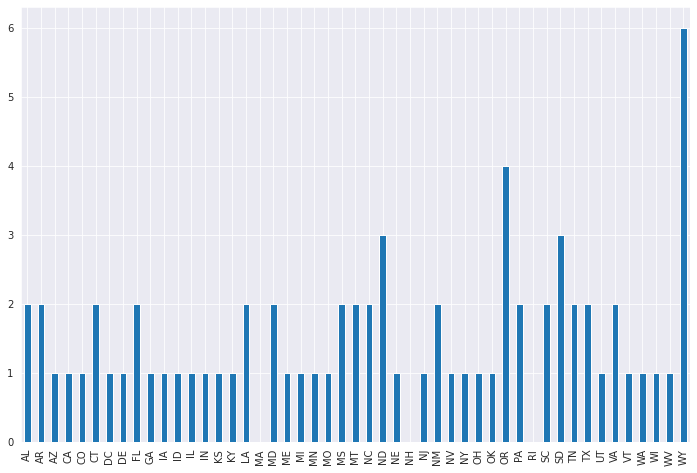

In [39]:
time_per_state['duration_mode'].plot(kind='bar', figsize=(12,8))

From the bar graph above, we can see that accidents in most states last an hour, just like the national duration. 

There are 19 states that do not follow this trend. They include: Arizona, Florida, Los Angeles, North Dakota, Oregon, South Dakota and Wyoming. Out of these eight, accidents last 2 hours for four of them whereas accidents in the other four last anywhere from 3 to 6 hours.

Let's also look into the times accidents start and end in each state. We'll compare the times to the national start and end times to see if they match. 

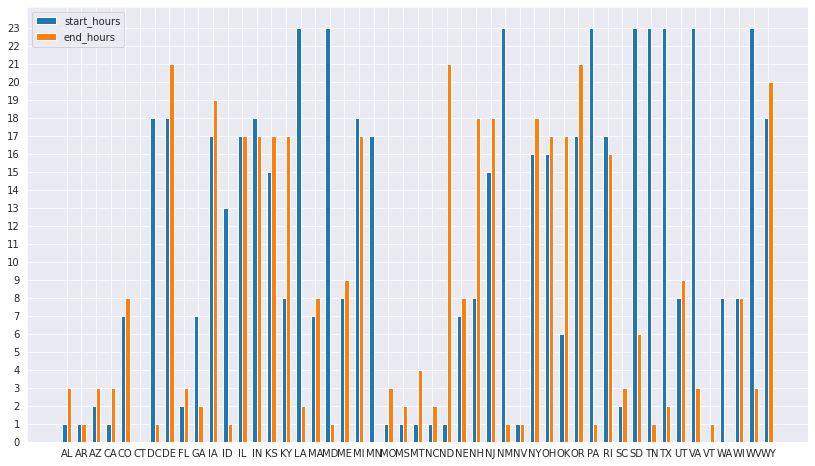

In [40]:
x = np.arange(len(time_per_state['start_hr_mode']))
width = 0.3
fig, ax = plt.subplots(figsize=(14,8))
start_hours = ax.bar(x-width/2, time_per_state['start_hr_mode'].astype(int), width, label='start_hours')
end_hours = ax.bar(x+width/2, time_per_state['end_hr_mode'].astype(float), width, label='end_hours')
plt.xticks(x, time_per_state['start_hr_mode'].index)
plt.yticks(np.arange(24))
ax.legend()
plt.show()

### Looking at the monthly distribution of accidents

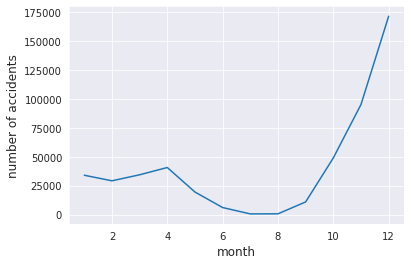

In [41]:
holiday_df = pd.DataFrame({
    'ID': weather_df.ID,
    'State': weather_df.State,
    'start_time': pd.to_datetime(weather_df['Start_Time']),
    'year': pd.to_datetime(weather_df['Start_Time']).dt.year,
    'month': pd.to_datetime(weather_df['Start_Time']).dt.month
    })
plt.xlabel('month', fontsize=12)
plt.ylabel('number of accidents', fontsize=12)
plt.plot(holiday_df.groupby(by='month')['ID'].count())

From this graph we can see that the number of traffic accidents tend to increase as the end of the year approaches. Starting in October, the closer we get to December, the more accidents there are.

I am assuming this is due to the holiday season. As the end of the year approaches, we are looking at major American holidays such as Thanksgiving, Black Friday, and Christmas. These holidays mean that more people are going out to purchase items to prepare for gatherings. They will also be going outside more frequently as well, as most people tend to split up their holiday shopping in multiple trips.

Let's now look at the top 5 states in terms of number of accidents and see if they also follow this trend. 

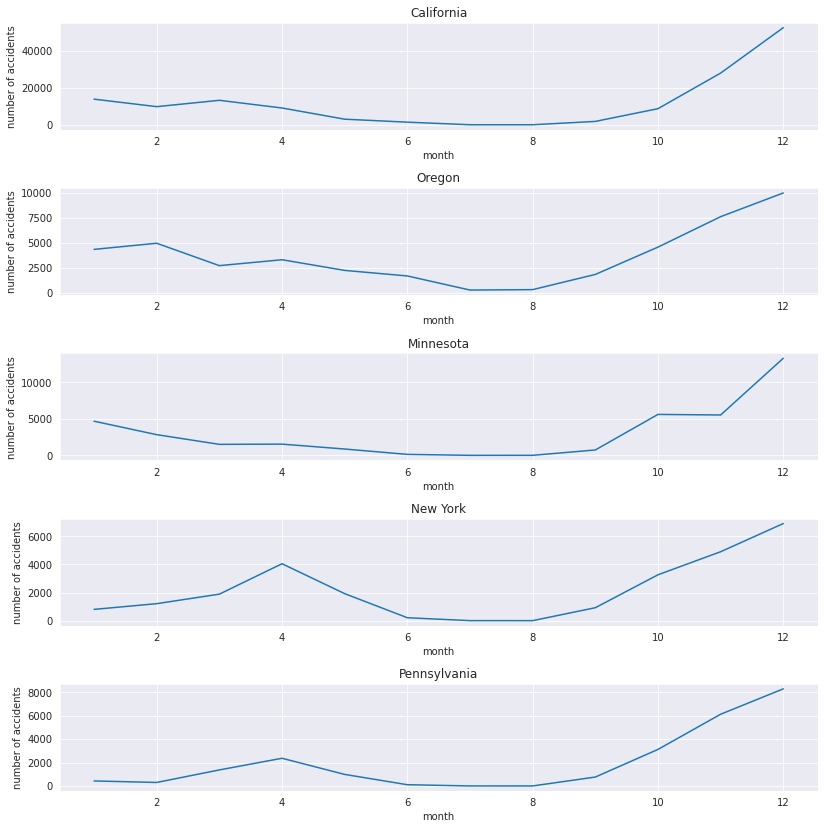

In [42]:
fig, ax = plt.subplots(5, figsize=(12,12))
fig.tight_layout(pad=3.75)
plt.setp(ax[:], xlabel='month')
plt.setp(ax[:], ylabel='number of accidents')

ax[0].title.set_text('California')
ax[1].title.set_text('Oregon')
ax[2].title.set_text('Minnesota')
ax[3].title.set_text('New York')
ax[4].title.set_text('Pennsylvania')

ax[0].plot(holiday_df[holiday_df['State'] == 'CA'].groupby('month')['ID'].count())
ax[1].plot(holiday_df[holiday_df['State'] == 'OR'].groupby('month')['ID'].count())
ax[2].plot(holiday_df[holiday_df['State'] == 'MN'].groupby('month')['ID'].count())
ax[3].plot(holiday_df[holiday_df['State'] == 'NY'].groupby('month')['ID'].count())
ax[4].plot(holiday_df[holiday_df['State'] == 'PA'].groupby('month')['ID'].count())


From the graphs above, we can say that the top five states by number of accidents *generally* follow the national trend. The number of accidents in each state start rapidly increasing around September and keep increasing until December. There is also a spike in April in each of the states. 

### **Weather Analysis**

I will be asking the following questions to understand if weather has an impact on accidents and accident severity:

1. **What weather factors make the biggest impact in terms of the severity of an accident?**
  - Compare different weather factors by severity to each other
  - Look at temperature, wind chill, precipitation, and weather condition 

2. **What type of weather correlates to the most severity?**
  - Look into the number of accidents for different weather conditions

3. **Are there specific times of the day where it is more 'dangerous' to drive?**
  - Increased number of accidents? Greater severity by time of day?

4. **Is precipitation an important factor when it comes to an accident's severity?**
  - Compare accidents with precipitation = 0 to accidents with precipitation > 0

5. **What weather factors are correlated to the severity of an accident?**
  - Look at temperature, wind chill, humidity, visibility, wind direction, wind speed, precipitation, and pressure(?)

#### Temperature
Let's start off by looking at *all* accidents by temperature. I made sure to bin the number of accidents by 10 degree buckets.

Text(0, 0.5, 'Number of Accidents')

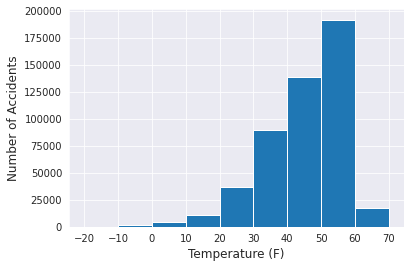

In [43]:
plt.hist(weather_df['Temperature(F)'], bins=np.arange(-20, 80, 10))
plt.xticks(np.arange(-20, 80, 10))
plt.xlabel('Temperature (F)', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)

Here we can see that the number of accidents keeps on increasing as the temperature increases. However this trend seems to end at the 60 degree mark, where there is a massive drop in the number of accidents.

Next I will look into the accidents by temperature, broken down by the severity of the accident as well.

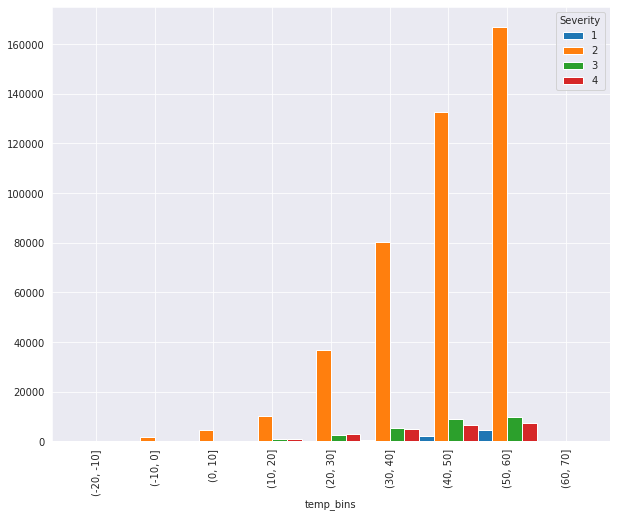

In [44]:
weather_df['temp_bins'] = pd.cut(weather_df['Temperature(F)'], bins=np.arange(-20, 80, 10))
weather_df.groupby(by=['temp_bins', 'Severity']).size().unstack(fill_value=0).plot.bar(width=1, figsize=(10,8))

From the graph above, we can see that the number of accidents increased as the temperature rises. The majority of accidents also have a severity of 2, and occured when the temperature was between 50 and 60 degrees (~170,000 accidents). 

We can also notice that there are a greater number of accidents with a severity of 4, the highest severity, than there are accidents with a severity of 1 for all temperatures. 

**Note:** The round brackets in the graph represent that the number is NOT included. For example, (40, 50] represents the range of numbers from 41 to 50 inclusive.

#### Weather condition
Next I will look deeper into the 'Weather_Condition' column.

In [45]:
len(weather_df['Weather_Condition'].unique())

92

As there are quite a lot of weather conditions in this dataset, I will only be looking at the top 10 by number of accidents. 

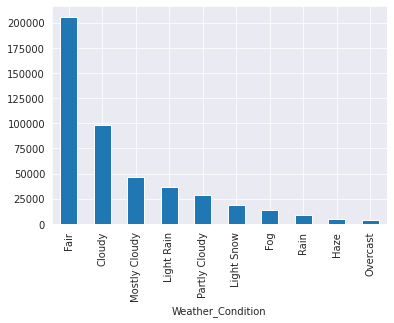

In [46]:
weather_cond = weather_df.groupby(by='Weather_Condition')['ID'].count().sort_values(ascending=False).head(10)
weather_cond.plot.bar()

By breaking down the weather conditions based on an accident's severity, we can see that "Cloudy" and "Fair" weather conditions have the most amount of most severe accidents. But one thing to keep into consideration is that they also have the highest and second highest number of accidents. As such, I will be looking at the percentage of accidents per severity for each weather condition. This will allow for a better comparison between the weather conditions when determining which condition contributed the most to more severe accidents. 

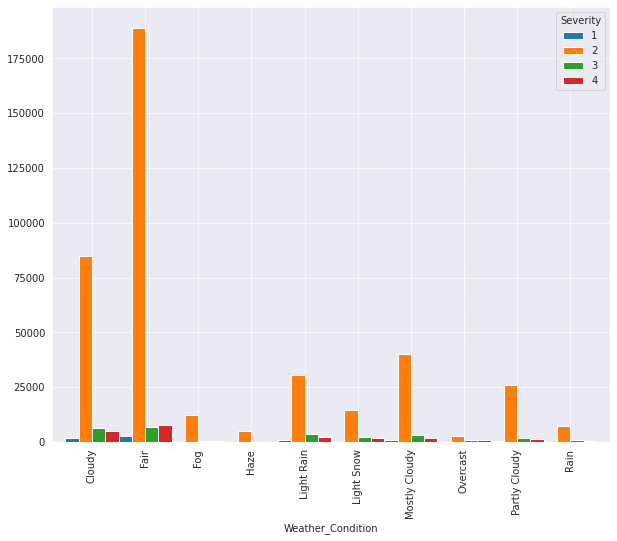

In [47]:
weather_cond_subset = weather_df.loc[weather_df['Weather_Condition']
                                     .isin(['Fair', 'Cloudy', 'Mostly Cloudy', 'Light Rain', 'Partly Cloudy', 'Light Snow', 'Fog', 'Rain', 'Overcast', 'Haze'])]
weather_cond_subset.groupby(by=['Weather_Condition', 'Severity']).size().unstack(fill_value=0).plot.bar(width=1, figsize=(10,8))

#### Precipitation

For this weather factor, I will compare the two 'categories' of precipitation: 
  - precipitation = 0
  - precipitation > 0

In [48]:
len(weather_df[weather_df['Precipitation(in)'] > 0]['Precipitation(in)'].unique())

89

##### Precipitation = 0

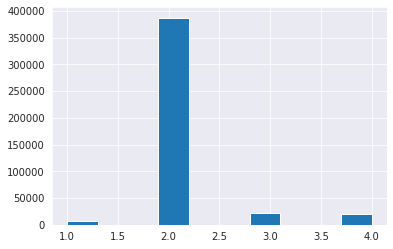

In [49]:
precip_zero = weather_df[weather_df['Precipitation(in)'] == 0].copy()
precip_zero['Severity'].hist()

##### Precipitation > 0


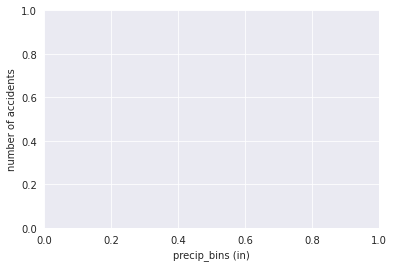

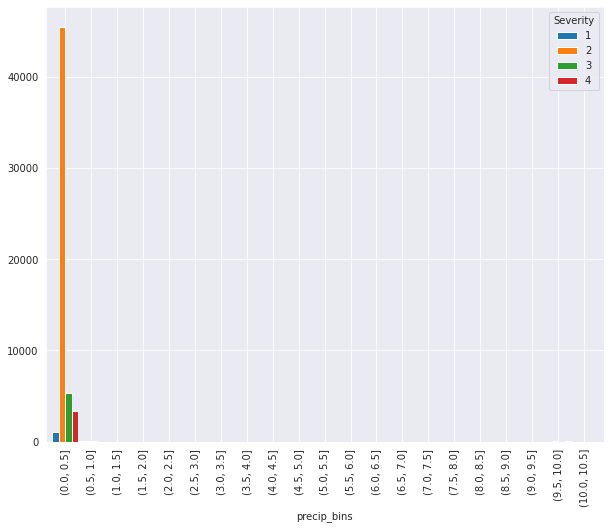

In [50]:
precip_more_zero = weather_df[weather_df['Precipitation(in)'] > 0].copy()
precip_more_zero['precip_bins'] = pd.cut(precip_more_zero['Precipitation(in)'], bins=np.arange(0.0, 11.0, 0.5))
plt.xlabel('precip_bins (in)')
plt.ylabel('number of accidents')
precip_more_zero.groupby(by=['precip_bins', 'Severity']).size().unstack(fill_value=0).plot.bar(width=1, figsize=(10,8))

I know that there are accidents with greater precipitation than what is shown in the bar graph above. The reason they are not showing is due to the large amount of accidents with precipitation between (0.0, 0.5] inches. As such, I will make another graph excluding this bucket of accidents to get a closer look at the other buckets. 

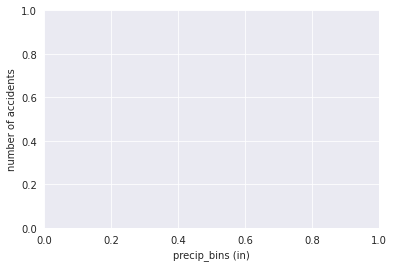

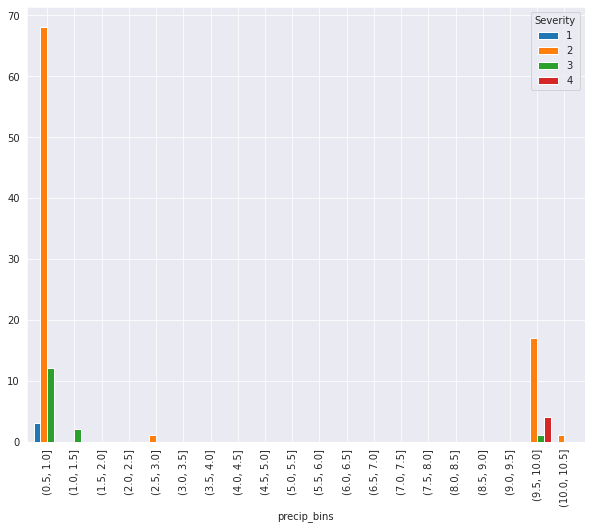

In [51]:
precip_more_zero_1 = weather_df[weather_df['Precipitation(in)'] > 0].copy()
precip_more_zero_1['precip_bins'] = pd.cut(precip_more_zero_1['Precipitation(in)'], bins=np.arange(0.5, 11.0, 0.5))
plt.xlabel('precip_bins (in)')
plt.ylabel('number of accidents')
precip_more_zero_1.groupby(by=['precip_bins', 'Severity']).size().unstack(fill_value=0).plot.bar(width=1, figsize=(10,8))

#### Time

Let's divide the accidents into four bins by when the accident began. I will seperate them into the following time periods: morning, afternoon, evening, and night, as opposed to looking at the accident breakdown per hour or per accident.

Precipitation > 0

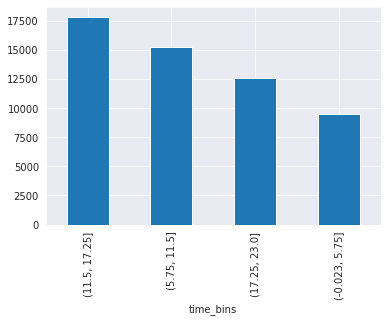

In [52]:
precip_more_zero['time_bins'] = pd.cut(pd.to_datetime(precip_more_zero['Start_Time']).dt.hour, bins = 4)
time_bins_grouped = precip_more_zero.groupby(by='time_bins')['ID'].count().sort_values(ascending=False)
time_bins_grouped.plot.bar()

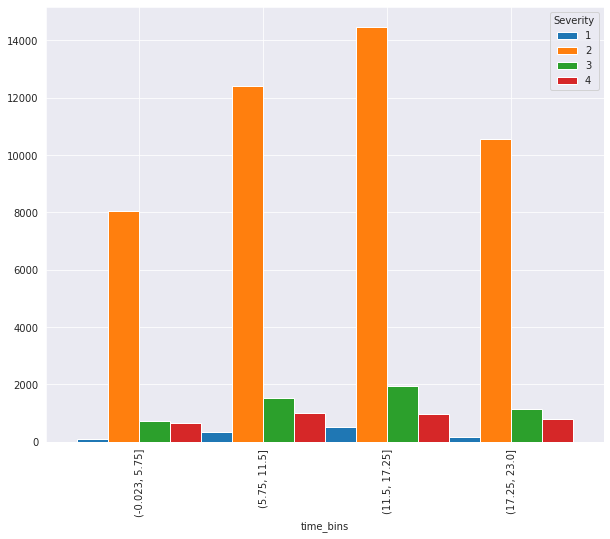

In [53]:
precip_more_zero.groupby(by=['time_bins', 'Severity']).size().unstack(fill_value=0).plot.bar(width=1, figsize=(10,8))

Precipitation = 0

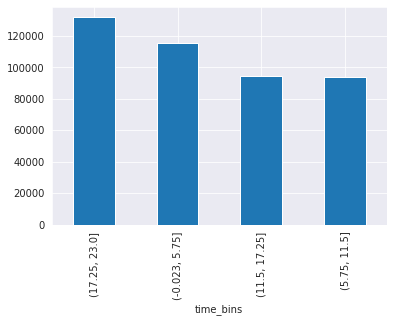

In [54]:
precip_zero['time_bins'] = pd.cut(pd.to_datetime(precip_zero['Start_Time']).dt.hour, bins = 4)
time_bins_precip_zero_grouped = precip_zero.groupby(by='time_bins')['ID'].count().sort_values(ascending=False)
time_bins_precip_zero_grouped.plot.bar()

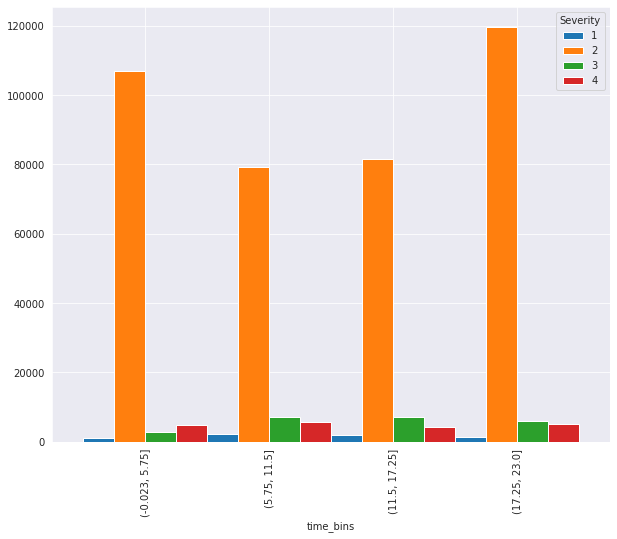

In [55]:
precip_zero.groupby(by=['time_bins', 'Severity']).size().unstack(fill_value=0).plot.bar(width=1, figsize=(10,8))

#### Correlation matrix to determine what factors are closely correlated to the severity of an accident

I am not including certain columns as it would not make sense to do so. For example, including the Start_Time in this matrix would not be meaningful as there is a high chance that all the Start_Times are different. As such, we would get a low correlation.

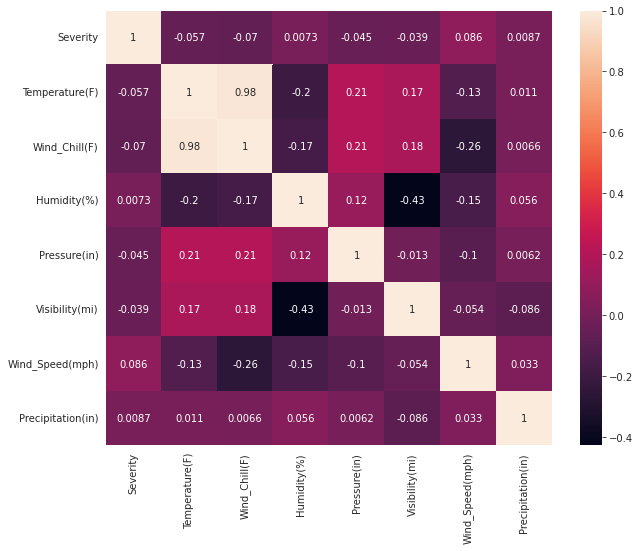

In [56]:
corr_matrix = weather_df[['Severity', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 
                          'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 
                          'Wind_Speed(mph)', 'Precipitation(in)']].corr()
plt.figure(figsize = (10,8))              
sns.heatmap(corr_matrix, annot=True)

By only looking at the 'Severity' column/row we can see how correlated the weather factors are with the severity of an accident. 

**Key Observations:**
  - Severity is most correlated to the wind speed at the time of the accident and is least correlated to the precipitation and humidity. 
  - Temperature and Wind Chill are also very closely correlated, these two variables are the most correlated out of all variables in the matrix
  - Humidity and Visibility are also somewhat correlated with a correlation coefficient of -0.45


**NOTE:** The closer the value in the square is to zero, the more the variables are *less correlated*. As such, the further the value in the square gets from zero, the *more correlated* the two variables are.

#References

*   Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

* Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.

*   https://www.ibm.com/cloud/learn/exploratory-data-analysis 
*   https://www.stat.cmu.edu/~hseltman/309/Book/chapter4.pdf 
* https://pandas.pydata.org/pandas-docs/stable/reference/general_functions.html
* https://www.timeanddate.com/astronomy/different-types-twilight.html 
* https://www.washingtonpost.com/weather/2020/08/16/death-valley-heat-record/
* https://www.mountwashington.org/about-us/history/world-record-wind.aspx#:~:text=For%20nearly%20sixty%2Dtwo%20years,by%20Mount%20Washington%20Observatory%20staff. 